<a href="https://colab.research.google.com/github/ValentinCord/HandOnAI_1/blob/main/Fire_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Hardware setup**

In [ ]:
!/opt/bin/nvidia-smi
!rm -rf sample_data

# **2. Dependencies**

In [ ]:
!pip install tf-explain

In [ ]:
# General
import numpy as np 
import os
import cv2
import csv
import math
import matplotlib
import imghdr
from tqdm import tdqm
from google.colab import drive

# Image
from IPython.display import Image, HTML, display
from matplotlib import pyplot as plt
from cycler import cycler
from PIL import Image, ImageEnhance

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input # 224*224
from keras.applications.xception import Xception, preprocess_input, decode_predictions # 299*299
from keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions # 224*224
from keras.applications.densenet import DenseNet121 # 224*224

from keras.preprocessing.image import ImageDataGenerator
from keras.losses import categorical_crossentropy
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Data augmentation 
from keras.preprocessing.image import ImageDataGenerator

# Explainability
import tf_explain

%load_ext tensorboard
print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

# **3. Data Loader**

In [ ]:
drive.mount('/content/gdrive')
drive_data_folder = '/content/gdrive/MyDrive/HandOnAI_1_Fire/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('File ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** Fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** You have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'/content/gdrive/MyDrive/HandOnAI_1_Fire/'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('Improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
        os.remove(bad_file_list[i])
else:
    print('No improper image files were found')

# **4. Train**

In [ ]:
!printf '%s\n' 'fire' 'no_fire' 'start_fire'> classes.txt

In [ ]:
configs = dict(
      nb_classes = 3,                         # fire, no_fire, start_fire
      batch_size = 64,                         # computed images before backpropagation
      input_dim = 224,                        # size of the input depending of the backbone
      epochs = 10,                             
      dataset_name = drive_data_folder,       # dataset loaded from google.drive
      classifier = "Xception",                # select the backbone
      pretrain_weights = 'imagenet',
      init_learning_rate = 0.001,
      lr_decay_rate = 0.1,
      optimizer = 'adam',                      # SGD, Adam, RMSprop
      loss_fn = 'categorical_crossentropy',   
      metrics = ['acc'],
      seed = 42,
      validation_split = 0.2
    )

tf.keras.utils.set_random_seed(configs['seed']) # Fixe seed to get more stable results

classes_path = 'classes.txt'
csv_path = 'result.csv'
log_path='logs'
result_path = 'results/' + configs['classifier']

In [ ]:
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

print(f'Classes : {classes}')
print(f'Number of classes : {num_classes}')

Classes : ['fire', 'no_fire', 'start_fire']
Number of classes : 3


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	configs['dataset_name'],          																		  # Path of the dataset
	validation_split = configs['validation_split'],             						# Data division : validation (20%), train (80%)
	subset = 'training',                																		# Selection of training data
	seed = configs['seed'],                          												# Initialization of random generator (for permutations)
	image_size = (configs['input_dim'], configs['input_dim']),    					# Input size of images
	batch_size = configs['batch_size'],																			# Batch_size
  label_mode = 'categorical'     																					# Conversion to One-Hot format
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
	configs['dataset_name'],          																		  # Path of the dataset
	validation_split = configs['validation_split'],             						# Data division : validation (20%), train (80%)
	subset = 'validation',              																		# Selection of validation data
	seed = configs['seed'],                         												# Initialization of random generator (for permutations)
	image_size = (configs['input_dim'], configs['input_dim']),    					# Input size of images
	batch_size = configs['batch_size'], 																		# Batch_size
  label_mode = 'categorical'     																					# Conversion to One-Hot format
)

Found 1869 files belonging to 3 classes.
Using 1496 files for training.
Found 1869 files belonging to 3 classes.
Using 373 files for validation.


In [ ]:
data_gen_args = dict(              
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20, width_shift_range=0.3, 
    height_shift_range=0.3,
    validation_split = 0.2,
    horizontal_flip = True,
    dtype = 'uint8'
)

color_datagen = ImageDataGenerator(**data_gen_args)

train_generator = color_datagen.flow_from_directory(
  configs['dataset_name'],          																		  # Path of the dataset             			
	subset = 'training',                																		# Selection of training data
	seed = configs['seed'],                         												# Initialization of random generator (for permutations)
	target_size = (configs['input_dim'], configs['input_dim']),    					# Input size of images
	batch_size = configs['batch_size'], 																		# Batch_size
  class_mode = 'categorical',
  shuffle = True
  )

val_generator = color_datagen.flow_from_directory(
  configs['dataset_name'],          																		  # Path of the dataset             			
	subset = 'validation',                																		# Selection of training data
	seed = configs['seed'],                         												# Initialization of random generator (for permutations)
	target_size = (configs['input_dim'], configs['input_dim']),    					# Input size of images
	batch_size = configs['batch_size'], 																		# Batch_size
  class_mode = 'categorical'
  )


Found 1497 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


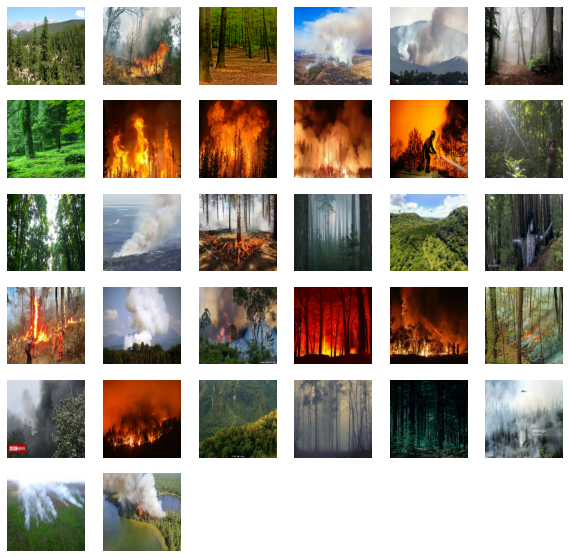

In [ ]:
plt.figure(figsize=(20, 20))
plt.suptitle('Train dataset', fontweight = 'bold', fontsize = 'xx-large')
for images, labels in train_ds.take(1):
    for i in range(32):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

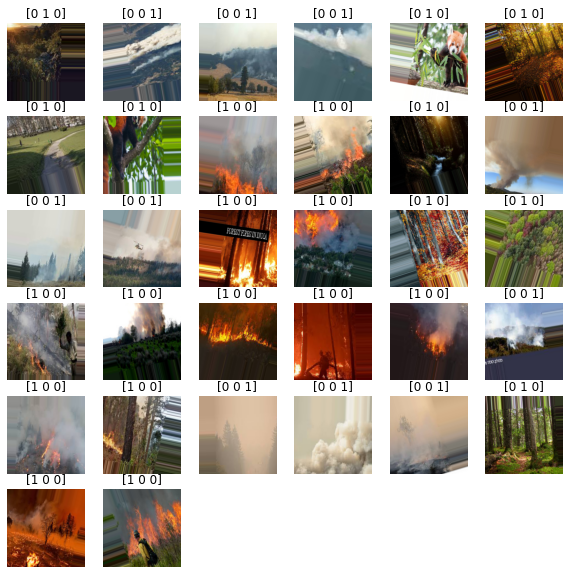

In [ ]:
plt.figure(figsize=(20, 20))
plt.suptitle('Train dataset', fontweight = 'bold', fontsize = 'xx-large')
images, label = next(train_generator)
for i in range(32):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(images[i])
    plt.title(label[i])
    plt.axis("off")

In [ ]:
!wget http://195.154.53.219/downloads/test.tar
!tar xf test.tar --one-top-level
!rm test.tar

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
	'/content/test/',          																		          # Path of the dataset               
	image_size = (configs['input_dim'], configs['input_dim']),    					# Input size of images				
  label_mode = 'categorical'     																					# Conversion to One-Hot format
)

data_generator_no_aug = ImageDataGenerator(dtype = 'uint8')
test_generator = data_generator_no_aug.flow_from_directory(
  '/content/test/',         																		          # Path of the dataset                      
	target_size = (configs['input_dim'], configs['input_dim']),    					# Input size of images
	batch_size = configs['batch_size'], 																		# Batch_size
  class_mode = 'categorical',
  )

Found 210 files belonging to 3 classes.
Found 210 images belonging to 3 classes.


In [ ]:
def build_model():

  base_model = Xception(
      include_top = False, 
      weights ='imagenet', 
      input_shape = (configs['input_dim'], configs['input_dim'],3))

  model = base_model.output
  model = Flatten()(model)
  model = Dense(128, activation='relu')(model)
  model = Dropout(0.4)(model)
  model = Dense(32, activation = 'relu',  name="layer2")(model)
  model = Dropout(0.4)(model)
  predictions = Dense(3, activation = 'softmax')(model)

  model = Model(inputs=base_model.inputs, outputs = predictions)

  return model

In [ ]:
model = build_model()
'''
model.summary()
tf.keras.utils.plot_model(
    model,
    to_file = 'model_summary.png',
    show_shapes = True,                 # show size of the layer
    show_dtype = False,                        
    show_layer_names = True,
    rankdir = 'TB',                     # TB : vertical ; LR : horizontal
    expand_nested = False,
    dpi = 70,                           # size of the graph
    layer_range = None,                 # pass a list of the first and the last layer to draw
    show_layer_activations = True       # show activation function type
)
'''

In [ ]:
def train(config: dict, callbacks: list, verbose: int=0):
  
  # https://stackoverflow.com/questions/57731214/what-tf-keras-backend-clear-session-actually-do
  tf.keras.backend.clear_session()                  
  
  model = build_model()

  # Select layers to be trained
  for layer in model.layers:
      layer.trainable = False       
  
  for layer in model.layers[:-6]:
      layer.trainable = True


  opt = keras.optimizers.SGD(learning_rate = config['init_learning_rate'])
  opt2 = keras.optimizers.Adam(learning_rate = config['init_learning_rate'])
  opt3 = keras.optimizers.RMSprop(learning_rate = config['init_learning_rate'])

  model.compile(loss = config['loss_fn'],
                optimizer = opt2,
                metrics = config['metrics'])  


  # Création du dossier pour sauvegrader le model
  if os.path.exists(result_path) == False:
      os.makedirs(result_path)

  history = model.fit_generator(
      train_generator,
      steps_per_epoch=math.ceil(len(train_generator)),
      epochs=config['epochs'],
      validation_data = val_ds,
      validation_steps=math.ceil(len(val_ds)),
      callbacks = callbacks
  )
  return model, history

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_path,
                                                      histogram_freq = 1)

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
stopper_callback = EarlyStopping(monitor = 'val_loss',
                                 patience = 5,
                                 mode='auto',
                                 restore_best_weights=True)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
ckpt_save = os.path.join('.', 'model_fine_ep_{epoch}_val_acc_{val_acc:.3f}.h5')
ckpt_callbak = ModelCheckpoint(cktp_save,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_best_only = True,
                               mode = 'auto')

# https://tf-explain.readthedocs.io/en/latest/usage.html#callbacks
def getTestImages(ds,class_index,n=32):   
    ds_unbatch = ds.unbatch()
    val_img = []
    val_label = []
    for image , label in tqdm.tqdm(ds_unbatch):
        #filter par indice de classe
        if np.argmax(label)==class_index:
            val_img.append(image.numpy().astype("float32") / 255.0)
            val_label.append(label)
    #prendre que n images pour test
    return (val_img[:n],val_label[:n])

val_class_0 = getTestImages(val_ds, class_index = 0, n = 10)
val_class_1 = getTestImages(val_ds, class_index = 1, n = 10)
val_class_2 = getTestImages(val_ds, class_index = 2, n = 10)

gradcam_0_callback = GradCAMCallback(validation_data = val_class_0,
                                     class_index = 0,
                                     output_dir = log_path)

gradcam_1_callback = GradCAMCallback(validation_data = val_class_1,
                                     class_index = 1,
                                     output_dir = log_path)

gradcam_2_callback = GradCAMCallback(validation_data = val_class_2,
                                     class_index = 2,
                                     output_dir = log_path)


In [ ]:
!rm -rf logs

callbacks = [tensorboard_callback,
             stopper_callback,
             ckpt_callbak,
             gradcam_0_callback, 
             gradcam_1_callback,
             gradcam_2_callback]

# Start training
model, history = train(configs, callbacks, 1)

loss, acc = model.evaluate(val_ds)
print(f'Validation loss: {loss}, validation accuracy : {acc}')
      
loss, acc = model.evaluate(test_ds)  
print(f'Test loss: {loss}, Test accuracy : {acc}')


In [ ]:
model.save('Xception_64_15.h5')

# **5. Callback XAI**

In [ ]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

In [ ]:
!tensorboard dev upload \
  --logdir  "/content/tf_explain/" \
  --one_shot

# **6. Post XAI**

/content/test//fire/test057.jpg
1/1 [==============================] - 1s 696ms/step


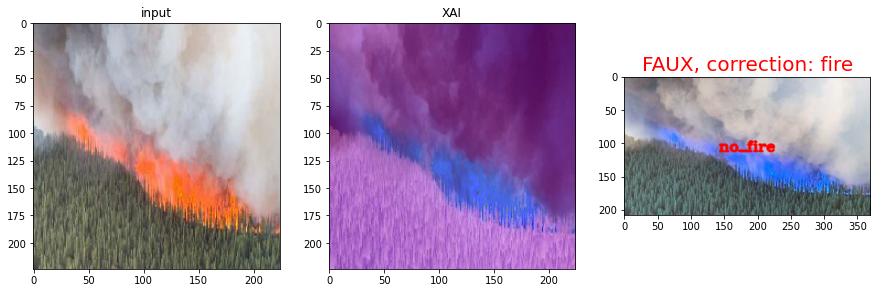

/content/test//fire/test026.jpg
1/1 [==============================] - 0s 23ms/step


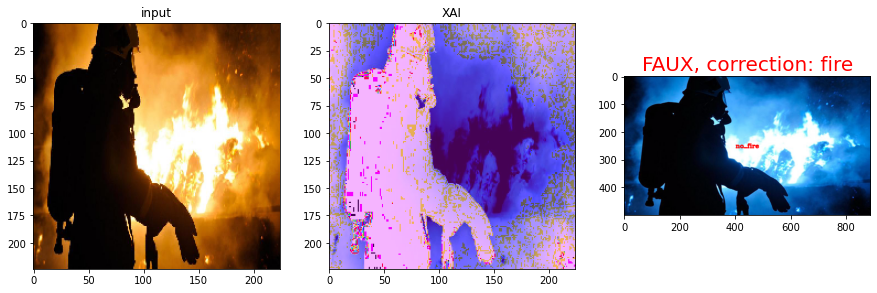

/content/test//fire/test067.jpg
1/1 [==============================] - 0s 24ms/step


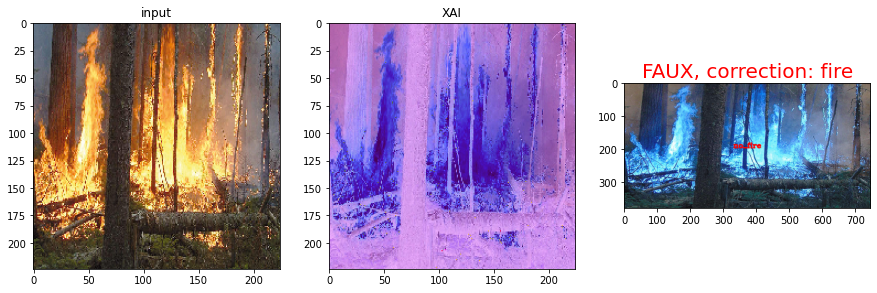

/content/test//fire/test030.jpg
1/1 [==============================] - 0s 26ms/step


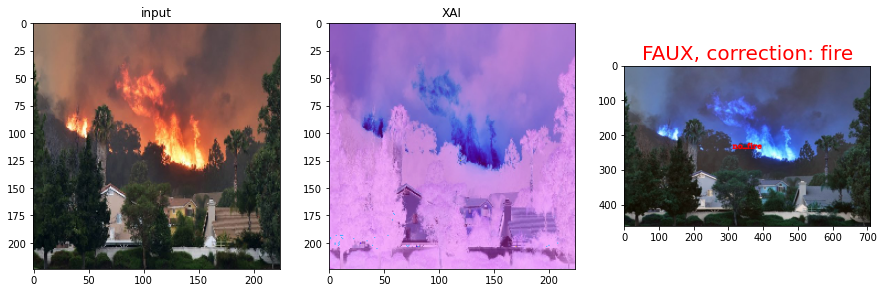

/content/test//fire/test044.jpg
1/1 [==============================] - 0s 21ms/step


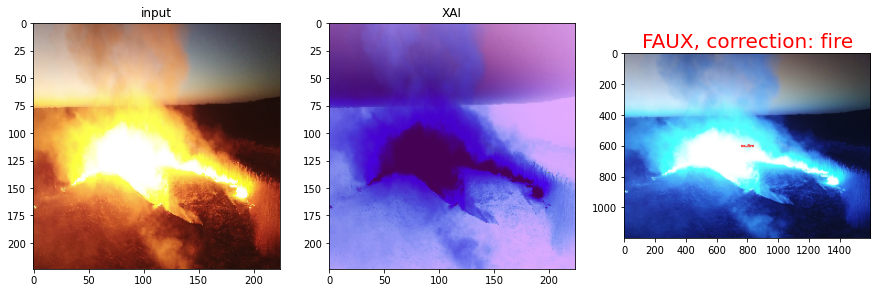

/content/test//fire/test053.jpg
1/1 [==============================] - 0s 27ms/step


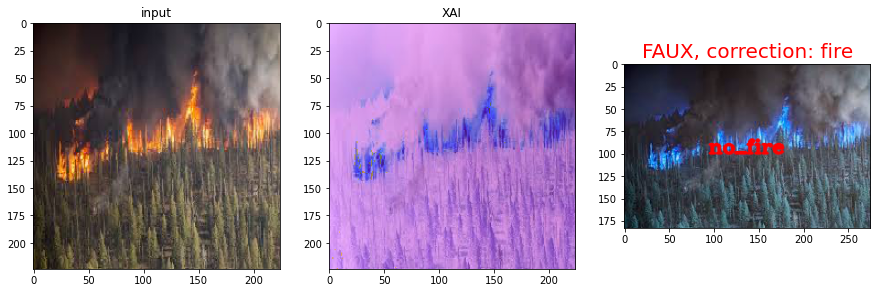

/content/test//fire/test056.jpg
1/1 [==============================] - 0s 24ms/step


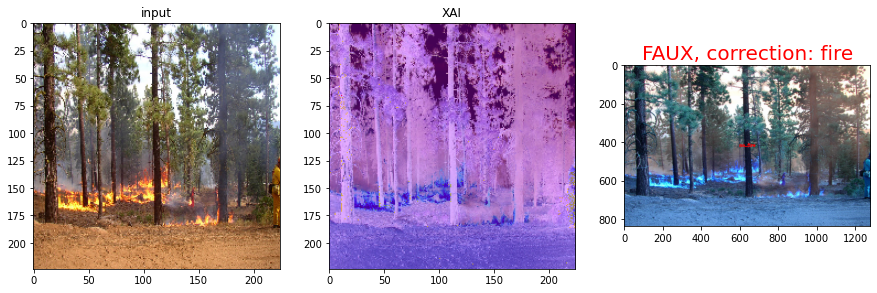

/content/test//fire/test063.jpg
1/1 [==============================] - 0s 35ms/step


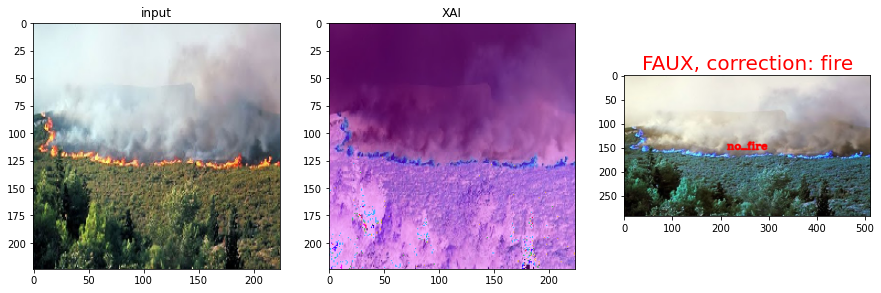

/content/test//fire/test013.jpg
1/1 [==============================] - 0s 29ms/step


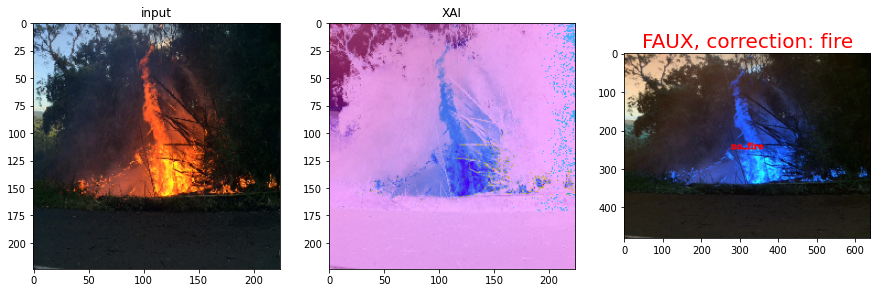

/content/test//fire/test050.jpg
1/1 [==============================] - 0s 26ms/step


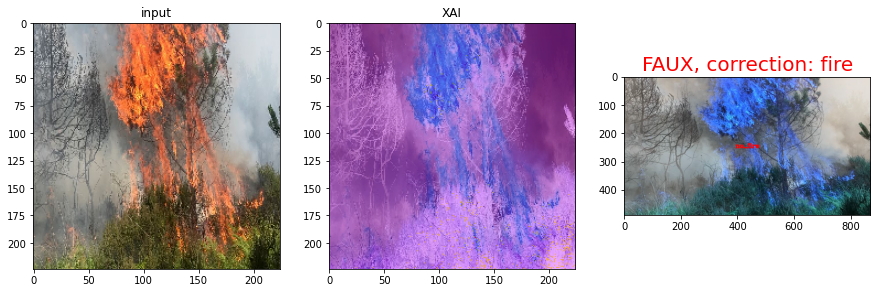

/content/test//fire/test034.jpg
1/1 [==============================] - 0s 34ms/step


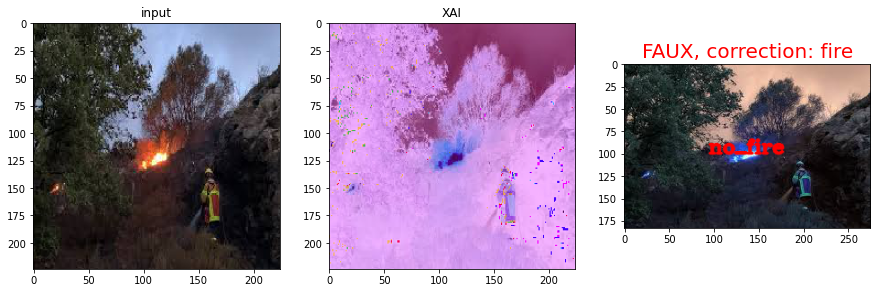

/content/test//fire/test031.jpg
1/1 [==============================] - 0s 27ms/step


KeyboardInterrupt: ignored

In [ ]:
from tf_explain.core.grad_cam import GradCAM
from skimage import io


path_test="/content/test/"
# Chosen class for which we want to apply XAI methods (to each class image)

for path in ['fire', 'no_fire', 'start_fire']: 
  for img_path in os.listdir(path_test + '/' + path):

      image_path = path_test + '/' + path + '/' + img_path
      className = path

      #imnum=[]
      print(image_path)
      # Load to the correct format and predict the current image
      img0 = tf.keras.preprocessing.image.load_img(image_path, target_size=(configs['input_dim'],configs['input_dim']))
      img = tf.keras.preprocessing.image.img_to_array(img0)

      data = ([img], None)
      xy=np.expand_dims(img,axis=0)
      myTuple=(xy,None)

      # Start explainer
      #explainer = SmoothGrad()
      explainer = GradCAM()
      grid = explainer.explain(myTuple, model, class_index=1)
      temp = np.concatenate((img,grid),axis=1)
      fig, axs = plt.subplots(1, 3)
      axs[0].imshow(img.astype(np.uint8))
      axs[0].set_title("input")
      axs[1].imshow(grid.astype(np.uint8))
      axs[1].set_title("XAI")

      fig.set_figheight(15)
      fig.set_figwidth(15)


      pred = model.predict(xy,batch_size=1)[0]
      for (pos,prob) in enumerate(pred):
        class_name_predicted = classes[pos]
        if (pos == np.argmax(pred)):
            isCorrect= class_name_predicted==className
            img = io.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            font = cv2.FONT_HERSHEY_COMPLEX 
            textsize = cv2.getTextSize(class_name_predicted, font, 0.7, 2)[0]
            textX = (img.shape[1] - textsize[0]) / 2
            textY = (img.shape[0] + textsize[1]) / 2
            cv2.putText(img, class_name_predicted, (int(textX), int(textY)), font, 0.7, (0,255,0) if  isCorrect else (255,0,0), 2, cv2.LINE_AA)
            axs[2].imshow(img)
            title_text =  "bonne prédiction" if isCorrect else "FAUX, correction: "+className
            title=axs[2].set_title(title_text, fontsize=20)
            plt.setp(title, color='g' if isCorrect else 'r') 
            
        #print("Top %d ====================" % (i + 1))
        #print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))

      plt.show()

In [ ]:
files.upload();

KeyboardInterrupt: ignored

In [ ]:
img = Image.open("50_fall.jpg").convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(224,224))
x = np.expand_dims(x, axis=0)
model.predict(x, 1)[0]

1/1 [==============================] - 0s 34ms/step


array([1., 0., 0.], dtype=float32)

In [ ]:
%matplotlib inline
image_path = "fog.jpg"
img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(224,224))
x = np.expand_dims(x, axis=0)
# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

In [ ]:
%tensorboard --logdir logs